In [8]:
import logging
import torch
import numpy as np
import matplotlib.pyplot as plt

from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import ActivationMode
from lava.proc.s4d.process import SigmaS4dDelta, S4d
from lava.proc.sparse.process import Sparse
from lava.proc.spike_integrator.process import SpikeIntegrator, SpikeIntegrator32



from lava.magma.core.run_conditions import RunSteps
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
from lava.utils.profiler import Profiler
from lava.lib.dl.slayer.state_space_models.sCIFAR.networks import SCIFARNetworkTorch
from lava.lib.dl.slayer.state_space_models.sCIFAR import utils
from lava.proc.receiver.process import Receiver
from lava.proc.spike_injector.process import InputProcess


import os
from lava.utils.system import Loihi2

loihi2_is_available = Loihi2.is_loihi2_available
if loihi2_is_available:
    # Enable SLURM, the workload manager used to distribute Loihi2 resources to users
    os.environ['SLURM'] = '1'
    os.environ['PARTITION'] = "oheogulch"
    os.environ['LOIHI_GEN'] = "N3C1"
    #os.environ["NXOPTIONS"] = "--vdd=0.65,--vddm=0.8"
import numpy as np


np.set_printoptions(linewidth=110)  # Increase the line lenght of output cells.
n_steps = 6000 #1024 # 1000 works

In [9]:
### try input_injector

from lava.proc.spike_injector.process import InputProcess
from lava.proc.dense.process import Dense
from lava.proc.spike_integrator.process import SpikeIntegrator
from lava.proc.embedded_io.spike import NxToPyAdapter


input = InputProcess(shape=(3,), sample_num=5, num_message_bits=24)
dense = Dense(weights=np.eye(3), num_message_bits=24)
spike_integrator = SpikeIntegrator(shape=(3,))
nx_adapter = NxToPyAdapter(shape=(3,), num_message_bits=24)
receiver = SinkBuffer(buffer=n_steps, shape=(3,))

input.out_port.connect(dense.s_in)
dense.a_out.connect(spike_integrator.a_in)
#spike_integrator.s_out.connect(nx_adapter.inp)
#nx_adapter.out.connect(receiver.a_in)

dense.run(
                    condition=RunSteps(num_steps=n_steps), run_cfg=Loihi2HwCfg()
                    )
received_data_hw = receiver.data.get()
received_data_hw = ((received_data_hw.astype(np.int32) << 8) >> 8).T
dense.stop()



Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.02%|  12.50%|   0.07%|   0.02%|   0.02%|   0.00%|   0.07%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       1|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


received_data_hw

In [10]:
_, _, val_loader = utils.get_datasets() 
label, data_sample1 = next(enumerate(val_loader)) 
label, data_sample2 = next(enumerate(val_loader))
label, data_sample3 = next(enumerate(val_loader))
label, data_sample4 = next(enumerate(val_loader))
label, data_sample5 = next(enumerate(val_loader))

Files already downloaded and verified
Files already downloaded and verified


In [11]:
data_rescaled = torch.transpose(data_sample5[0], -1,-2)
diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
data_sample_final = torch.from_numpy(np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2)).detach().numpy()[0].T * 2**12
final_string = "{"
for row in data_sample_final:
    for idx, col in enumerate(row):
        final_string += str(int(col)) 
        if idx in [0,1]:
            final_string += ", "
    final_string += "},\n {"
print(final_string)

{5851, 6286, 5205},
 {-4049, -3383, -4395},
 {873, 724, -79},
 {-238, -322, -799},
 {794, 966, 239},
 {1429, 1127, 1598},
 {714, 402, 1278},
 {873, 886, 1118},
 {1032, 1127, 1038},
 {1111, 563, -958},
 {635, -161, -1838},
 {158, -483, -1518},
 {-317, -1047, -1997},
 {-238, 0, 399},
 {158, 322, 399},
 {-317, -1127, -3196},
 {-238, -563, -799},
 {-158, -241, -799},
 {-79, -402, 958},
 {-3017, -1611, 3676},
 {-5875, -3786, 399},
 {-3255, -2658, -2237},
 {-1429, -1611, -1438},
 {714, 886, 719},
 {476, 1047, 1038},
 {-794, -1047, -1198},
 {-635, -886, -1278},
 {873, 966, 1518},
 {-238, -241, -239},
 {-476, -563, -319},
 {1588, 1772, 1838},
 {5637, 4672, 4475},
 {4764, 5074, 2796},
 {-397, -1127, -2077},
 {2779, 2497, 1358},
 {-79, 241, -479},
 {317, 724, 319},
 {555, 724, 1598},
 {317, 322, 559},
 {79, 80, -239},
 {238, -241, -1598},
 {-79, -1449, -4635},
 {-555, -1611, -3596},
 {-714, -1449, -1917},
 {-317, -724, -1198},
 {-2461, -966, 3835},
 {952, 2255, 4714},
 {-1508, -1933, -2796},
 {-

In [12]:
# Model
print('==> Building model..')
model = SCIFARNetworkTorch(
    d_input=3,
    d_output=10,
    d_model=128,
    d_state=4,
    n_layers=1,
    dropout=0,
    get_last=False,
    #prenorm=args.prenorm,
)

model.encoder.qconfig = torch.quantization.default_qat_qconfig
model.ff_layers[0].qconfig = torch.quantization.default_qat_qconfig
model.decoder.qconfig = torch.quantization.default_qat_qconfig
torch.quantization.prepare_qat(model, inplace=True);

checkpoint = torch.load('/home/sveamari/lava_dev/checkpoint/4_states_quantized_ckpt.pth')
model.load_state_dict(checkpoint['model'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']
model.eval()
model_converted = torch.quantization.convert(model, inplace=False)

# get weights
# for encoder
w0 = model_converted.encoder.weight()
wf0 = torch.dequantize(w0)
encoder_weight = wf0 / w0.q_scale()

# for ff layer
w1 = model_converted.ff_layers[0][0].weight()
wf1 = torch.dequantize(w1)
ff_weight = wf1 / w1.q_scale()

# for decoder
w2 = model_converted.decoder.weight()
wf2 = torch.dequantize(w2)
decoder_weight = wf2 / w2.q_scale()

==> Building model..


#### Create Lava Network

In [13]:
# S4 stuff
model_dim = 128
d_states = 4
model.s4_layers[0].setup_step()
A = model.s4_layers[0].layer.kernel.dA.detach().numpy()
B = model.s4_layers[0].layer.kernel.dB.detach().numpy()
C = model.s4_layers[0].layer.kernel.dC.detach().numpy()

def example_run(profile, sample):
    kron_matrix = np.kron(np.eye(model_dim), np.ones((d_states, )))



    #encoder
    input = InputProcess(shape=(3,), sample_num=sample, num_message_bits=24)
    dense_1 = Sparse(weights=encoder_weight.numpy(), num_message_bits=24)
    encoder = SpikeIntegrator(shape=(model_dim,), q_scale=w0.q_scale(), q_exp=15, relu_flag=False)

    # S4D
    dense_2 = Sparse(weights=kron_matrix.T, weight_exp=6, num_message_bits=24)
    neuron = S4d(shape=((model_dim * d_states,)), state_exp = 6, s4_exp = 12,    # state exp doesn't get used here, currently hard coded to 6
                            a=A.flatten().reshape((model_dim * d_states,)),
                            b=B.flatten().reshape((model_dim * d_states,)),
                            c=C.flatten().reshape((model_dim * d_states,)))
    dense_3 = Sparse(weights=kron_matrix, num_message_bits=24, weight_exp=6)
    relay = SpikeIntegrator(shape=(model_dim,), relu_flag=False, q_scale=1/(2**6), q_exp=6)

    # FF
    dense_4 = Sparse(weights=ff_weight.numpy(), num_message_bits=24)
    ff_neuron = SpikeIntegrator(shape=(model_dim,), relu_flag=True, q_scale=w1.q_scale(), q_exp=15)

    # decoder
    dense_5 = Sparse(weights=decoder_weight.numpy(), num_message_bits=24)
    decoder_neuron =SpikeIntegrator(shape=(10,), relu_flag=False, q_scale = w2.q_scale(), q_exp=10)

    # output
    dense_to_on_chip = Sparse(weights=np.eye(10), num_message_bits=24)  
    on_chip_receiver = Receiver(shape=(10,))


    # connect
    input.out_port.connect(dense_1.s_in)
    dense_1.a_out.connect(encoder.a_in)
    encoder.s_out.connect(dense_2.s_in)
    dense_2.a_out.connect(neuron.a_in)
    neuron.s_out.connect(dense_3.s_in)
    dense_3.a_out.connect(relay.a_in)
    relay.s_out.connect(dense_4.s_in)
    dense_4.a_out.connect(ff_neuron.a_in)
    ff_neuron.s_out.connect(dense_5.s_in)
    dense_5.a_out.connect(decoder_neuron.a_in)
    decoder_neuron.s_out.connect(dense_to_on_chip.s_in)
    dense_to_on_chip.a_out.connect(on_chip_receiver.a_in)


    run_cfg = Loihi2HwCfg()
    
    # set up profiler
    if profile == "energy":
        profiler = Profiler.init(run_cfg)
        profiler.energy_probe(num_steps=n_steps)
        profiler.activity_probe()
        profiler.memory_probe()
    elif profile == "time":
        profiler = Profiler.init(run_cfg)
        profiler.execution_time_probe(num_steps=n_steps)
    else:
        profiler = None
    

    
    encoder.run(
                    condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg
                    )
    encoder.stop()
    return profiler






In [14]:
total_times = []
total_energies = []
a = []
for i in range(1,6):
    times_here = []
    energies_here = []
    a_here = []
    for _ in range(1):
        energy_profiler = example_run("energy", i)
        time_profiler = example_run("time", i)
        times_here.append(np.round(np.sum(time_profiler.execution_time), 6))
        energies_here.append(np.round(energy_profiler.power, 6)) 
        a_here.append(f"sample {i}")
    total_times.append(times_here)
    total_energies.append(energies_here)
    a.append(a_here)



end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


end
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.06%|   0.06%|   0.00%|   0.21%|       1|
|   0.80%|  12.50%|   0.24%|   3.08%|   0.06%|   0.00%|   3.21%|       1|
|   0.80%|  12.50%|   3.13%|  30.21%|   0.80%|   0.00%|  26.09%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.67%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
a= np.asarray(a).flatten()
total_times = np.asarray(total_times).flatten()
total_energies = np.asarray(total_energies).flatten()
# add yrange
ax[0].set_ylim([0, 0.5])
ax[0].plot(a, total_times, marker= "o", linestyle = "")
ax[0].set_ylabel("Time in seconds")
ax[0].set_title("Execution time for 5 runs of S4D (6000 timesteps)")
ax[1].plot(a, total_energies, marker= "o", linestyle = "")
ax[1].set_ylim([0, 0.5])
# set y label
ax[1].set_ylabel("Power in Watt")
ax[1].set_title("Power Measurement for 5 runs of S4D")

# i dont want the markers to be connected


In [ ]:
print(f"Total execution time: {np.round(np.sum(time_profiler.execution_time), 6)} s")
print(f"Total power: {np.round(energy_profiler.power, 6)} W") 
print(f"Total energy: {np.round(energy_profiler.energy, 6)} J")
print(f"Static energy: {np.round(energy_profiler.static_energy, 6)} J") 

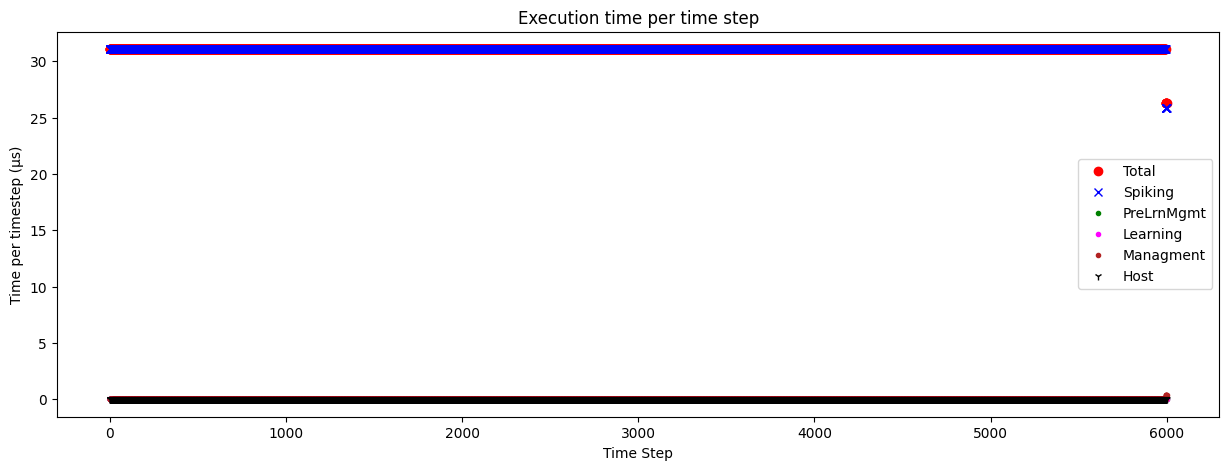

In [15]:
time_profiler.plot_execution_time()

In [ ]:
energy_profiler.statement

In [ ]:
energy_profiler.power_breakdown()
energy_profiler.energy_breakdown()
energy_profiler.plot_activity()
